In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from pprint import pprint

In [2]:
patients = pd.read_csv('./Robo/Data/patient.csv',index_col='PatientGuid').sort_index()
diagnosis = pd.read_csv('./Robo/Data/diagnosis.csv',index_col='PatientGuid').sort_index()
physicians = pd.read_csv('./Robo/Data/physician_specialty.csv',index_col='PatientGuid').sort_index()
transcripts = pd.read_csv('./Robo/Data/transcript.csv',index_col='PatientGuid').sort_index()
#medications = pd.read_csv('./Robo/Data/medication.csv',index_col='PatientGuid').sort_index()
medication_new = pd.read_csv('./Robo/Data/medic_new.csv',index_col='PatientGuid').sort_index()
#medications.columns = map(lambda x:'med_'+x,medications.columns)
#data = pd.concat([diagnosis,physicians,transcripts,medications,patients], axis=1)
data = pd.concat([diagnosis,physicians,transcripts,medication_new,patients], axis=1)
data.fillna(0,inplace=True)

#create artificial IDs, to keep track of training and validation sets later

data['ID'] = range(data.shape[0])

c:\users\rupadhyay\python 3.6\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 00023761-9D8D-445B-874C-2424CC7CF620 to FFF5C634-1CF7-40D5-BDF1-4FA2D62D9C63
Columns: 2678 entries, Icd9_001-139 to ID
dtypes: float64(2650), int32(1), int64(27)
memory usage: 203.3+ MB


In [3]:
target = 'DMIndicator'
categorical = ['Gender','State']
categorical += [x for x in data.columns if 'Icd' in x]
categorical += [x for x in data.columns if 'PhySp' in x]
numerical = data[[x for x in data.columns if (x not in categorical)]].columns.tolist()
categorical += ['ID']


### Functions for Visualization

In [4]:


def box_numerical(df,col,target='DMIndicator',ylim=[0,25]):
    
    plt.figure(figsize=(5,3))
    plt.boxplot([df[col][df[target] == 0],df[col][df[target] == 1]])
    plt.xticks([1,2],[0,1])
    plt.ylim(ylim)
    plt.ylabel(col)
    print (col,stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0]))

In [5]:
def hist_numerical(df,col):
    x = data[col]
    plt.hist([x[data['DMIndicator'] == 1],x[data['DMIndicator'] == 0]],bins=20)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend([1,0],title='DMIndicator')
    plt.show()

In [8]:
numerical

['DiagnosisCount',
 'VisitCount',
 'DiagnosisFreq',
 'AcuteCount',
 'AcuteFreq',
 'Height_Max',
 'Weight_Max',
 'BMI_Max',
 'SystolicBP_Max',
 'DiastolicBP_Max',
 'RespiratoryRate_Max',
 'Temperature_Max',
 'Height_Min',
 'Weight_Min',
 'BMI_Min',
 'SystolicBP_Min',
 'DiastolicBP_Min',
 'RespiratoryRate_Min',
 'Temperature_Min',
 'Height_Std',
 'Weight_Std',
 'BMI_Std',
 'SystolicBP_Std',
 'DiastolicBP_Std',
 'RespiratoryRate_Std',
 'Temperature_Std',
 'Height_Mean',
 'Weight_Mean',
 'BMI_Mean',
 'SystolicBP_Mean',
 'DiastolicBP_Mean',
 'RespiratoryRate_Mean',
 'Temperature_Mean',
 'BMI_Change',
 'DiastolicBP_Change',
 'Height_Change',
 'RespiratoryRate_Change',
 'SystolicBP_Change',
 'Temperature_Change',
 'Weight_Change',
 'MedicationName_A/B Otic (antipyrine-benzocaine otic) otic solution',
 'MedicationName_ALPRAZolam ER (ALPRAZolam) oral tablet, extended release',
 'MedicationName_AMILoride HCl-Hydrochlorothiazide (aMILoride-hydrochlorothiazide) oral tablet',
 'MedicationName_AMILo

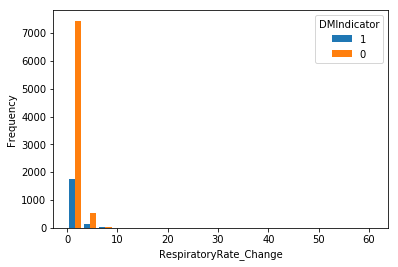

In [32]:
hist_numerical(data,'RespiratoryRate_Change')


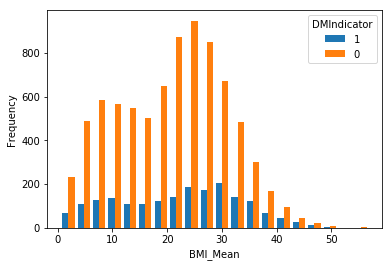

In [33]:
hist_numerical(data,'BMI_Mean')

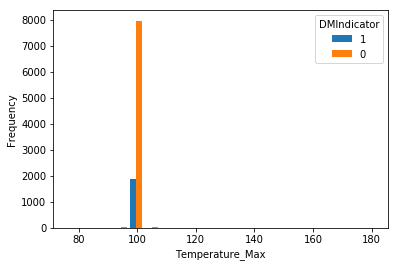

In [34]:
hist_numerical(data,'Temperature_Max')

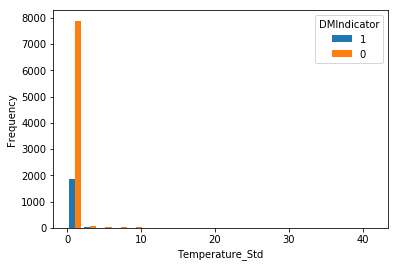

In [35]:
hist_numerical(data,'Temperature_Std')

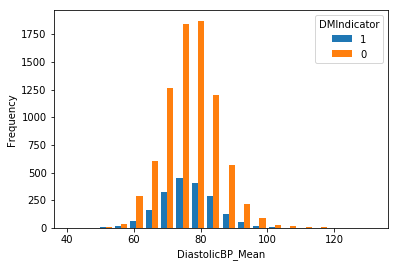

In [36]:
hist_numerical(data,'DiastolicBP_Mean')

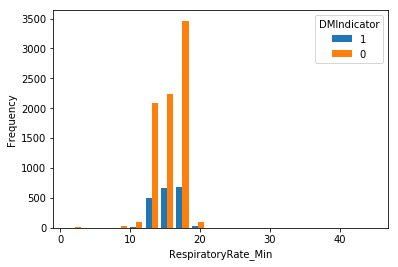

In [37]:
hist_numerical(data,'RespiratoryRate_Min')

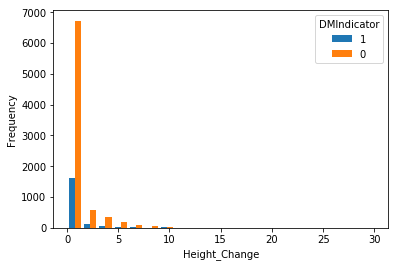

In [38]:
hist_numerical(data,'Height_Change')

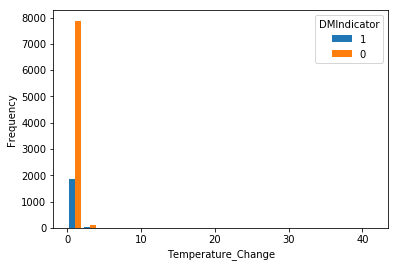

In [39]:
hist_numerical(data,'Temperature_Change')

In [6]:
#after having a look at each variable, following are found to be non important
non_important = ['Temperature_Max',
                'Temperature_Std','Height_Change','RespiratoryRate_Change',
                 'Temperature_Change']

In [47]:
numerical

['DiagnosisCount',
 'VisitCount',
 'DiagnosisFreq',
 'AcuteCount',
 'AcuteFreq',
 'Height_Max',
 'Weight_Max',
 'BMI_Max',
 'SystolicBP_Max',
 'DiastolicBP_Max',
 'RespiratoryRate_Max',
 'Temperature_Max',
 'Height_Min',
 'Weight_Min',
 'BMI_Min',
 'SystolicBP_Min',
 'DiastolicBP_Min',
 'RespiratoryRate_Min',
 'Temperature_Min',
 'Height_Std',
 'Weight_Std',
 'BMI_Std',
 'SystolicBP_Std',
 'DiastolicBP_Std',
 'RespiratoryRate_Std',
 'Temperature_Std',
 'Height_Mean',
 'Weight_Mean',
 'BMI_Mean',
 'SystolicBP_Mean',
 'DiastolicBP_Mean',
 'RespiratoryRate_Mean',
 'Temperature_Mean',
 'BMI_Change',
 'DiastolicBP_Change',
 'Height_Change',
 'RespiratoryRate_Change',
 'SystolicBP_Change',
 'Temperature_Change',
 'Weight_Change',
 'MedicationName_A/B Otic (antipyrine-benzocaine otic) otic solution',
 'MedicationName_ALPRAZolam ER (ALPRAZolam) oral tablet, extended release',
 'MedicationName_AMILoride HCl-Hydrochlorothiazide (aMILoride-hydrochlorothiazide) oral tablet',
 'MedicationName_AMILo

### Feature selection

In [7]:
#import scikit learn libraries
from sklearn import cross_validation, metrics #model optimization and valuation tool
from sklearn.grid_search import GridSearchCV #performing grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests i

In [8]:
#create functions to tune parameters

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,cv_folds=5):
    #Train the algorithm on data, This functions train the model given as 'alg' by performing cross-validation
    alg.fit(dtrain[predictors],dtrain[target])
    
    #predict on training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors]) [:,1]
    
    #Perform cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print ("\n Model Report: ")
        if (scoring_method == 'roc_auc'):
            print("Accuracy : ",metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print("AUC score (Train):", metrics.roc_auc_score(dtrain[target],dtrain_predprob))  
        
        if (scoring_method == 'mean_squared_error'):
            print("Accuracy : ",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    
    if performCV:
        print("CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
    plt.figure(figsize=(30,27))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
           
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    #This functions is used to tune paremeters of a predictive algorithm
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring = scoring_method, n_jobs=2,iid=False, cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch
    

In [21]:
#Create different set of labels 

labels1 = list(filter(lambda x: not x.startswith('Med'),list(set(numerical).difference(set(non_important)))))  #Numerical

labels1.pop(labels1.index('DMIndicator'))
labels2 = categorical[:]
labels3 = ['ID','Icd9_390-459', 'State', 'Icd9_240-279', 'PhySp_Internal_Medicine', 'PhySp_Family_Practice', 'PhySp_General_Practice', 'Icd9_780-799', 'PhySp_Unknown', 'Icd9_710-739', 'Icd9_E-V', 'Gender', 'PhySp_Geriatric_Medicine', 'Icd9_290-319', 'PhySp_Podiatry', 'PhySp_Cardiovascular_Disease', 'PhySp_Pulmonary_Disease', 'Icd9_580-629', 'PhySp_Endocrinology__Diabetes__Metabolism', 'PhySp_Adolescent_Medicine', 'PhySp_Nephrology', 'Icd9_280-289', 'Icd9_460-519', 'Icd9_320-359', 'Icd9_680-709', 'Icd9_520-579']

labels4 = list(filter(lambda x: x.startswith('Med'),data.columns))+['ID']
#gbm_med_feature_list = gbm_med_feature_list+['ID']

#split data into training and validation sets
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels2],data[target],test_size=1/4.,random_state=123)
#_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels4],data[target],test_size=1/4.,random_state=123)
#_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[gbm_med_feature_list],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

In [22]:
labels1.pop(labels1.index('ID'))
labels2.pop(labels2.index('ID'))
labels3.pop(labels3.index('ID'))
labels4.pop(labels4.index('ID'))

'ID'

## Selecting features

## Medicine Features


 Model Report: 
Accuracy :  0.8287092882991556
AUC score (Train): 0.7433965136900784
CV Score - Mean : 0.6832045 | Std : 0.01408319 | Min : 0.6627017 | Max : 0.6988488


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

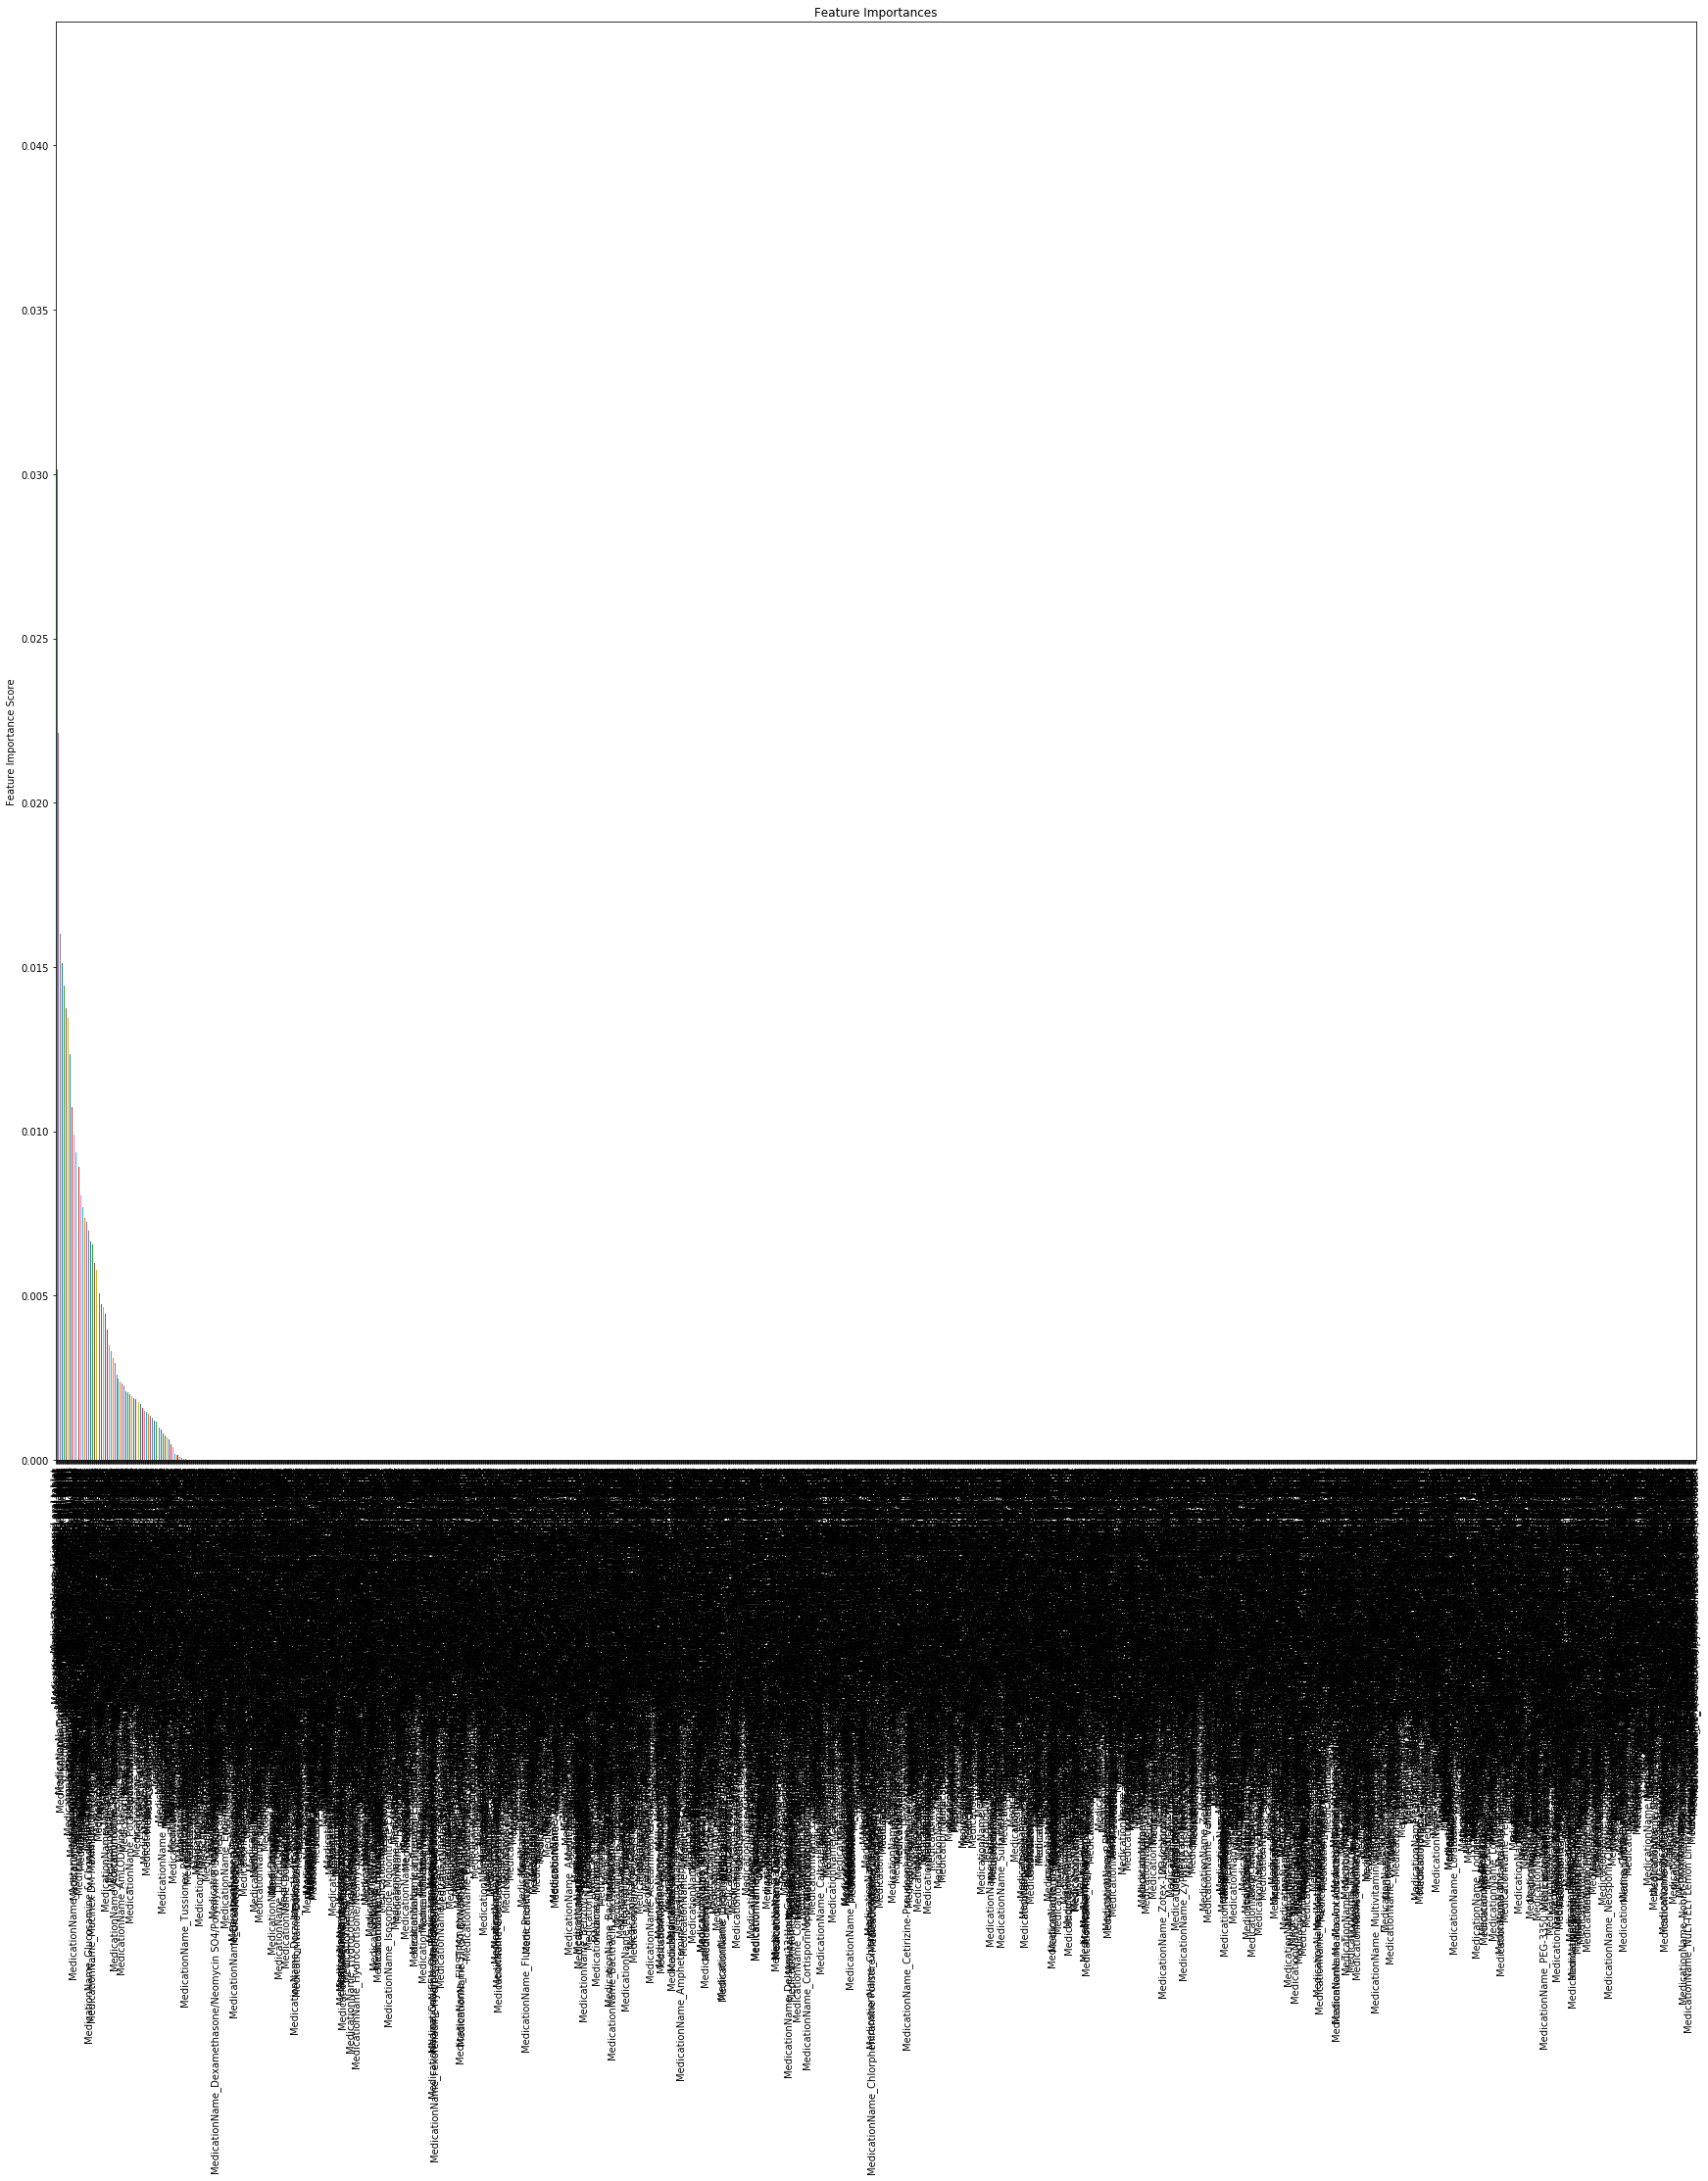

In [18]:
# Testing Model with all features and default values
predictors = labels4
train = _Xtrain.copy()
train['DMIndicator'] = _Ytrain
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors,target,'roc_auc')

In [19]:
imp_med_features = gbm0.feature_importances_.argsort()[::-1][:50]
med_feature_list = [labels4[i] for i in imp_med_features]
med_feature_list

['MedicationName_Lisinopril oral tablet',
 'MedicationName_Zocor (simvastatin) oral tablet',
 'MedicationName_Simvastatin oral tablet',
 'MedicationName_Cozaar (losartan) oral tablet',
 'MedicationName_Lasix (furosemide) oral tablet',
 'MedicationName_Lipitor (atorvastatin) oral tablet',
 'MedicationName_Gabapentin oral capsule',
 'MedicationName_Hyzaar (hydrochlorothiazide-losartan) oral tablet',
 'MedicationName_Trilipix (fenofibric acid) oral delayed release capsule',
 'MedicationName_TriCor (fenofibrate) oral tablet',
 'MedicationName_Mevacor (lovastatin) oral tablet',
 'MedicationName_Coreg (carvedilol) oral tablet',
 'MedicationName_TriCor (fenofibrate) oral capsule',
 'MedicationName_Enalapril Maleate (enalapril) oral tablet',
 'MedicationName_Acarbose oral tablet',
 'MedicationName_Pravastatin Sodium (pravastatin) oral tablet',
 'MedicationName_Pravachol (pravastatin) oral tablet',
 'MedicationName_Lovastatin oral tablet',
 'MedicationName_Crestor (rosuvastatin) oral tablet',
 

## Categorical Features


 Model Report: 
Accuracy :  0.8316579546977617
AUC score (Train): 0.8231788688438082
CV Score - Mean : 0.7721004 | Std : 0.008606074 | Min : 0.7580999 | Max : 0.7840198


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

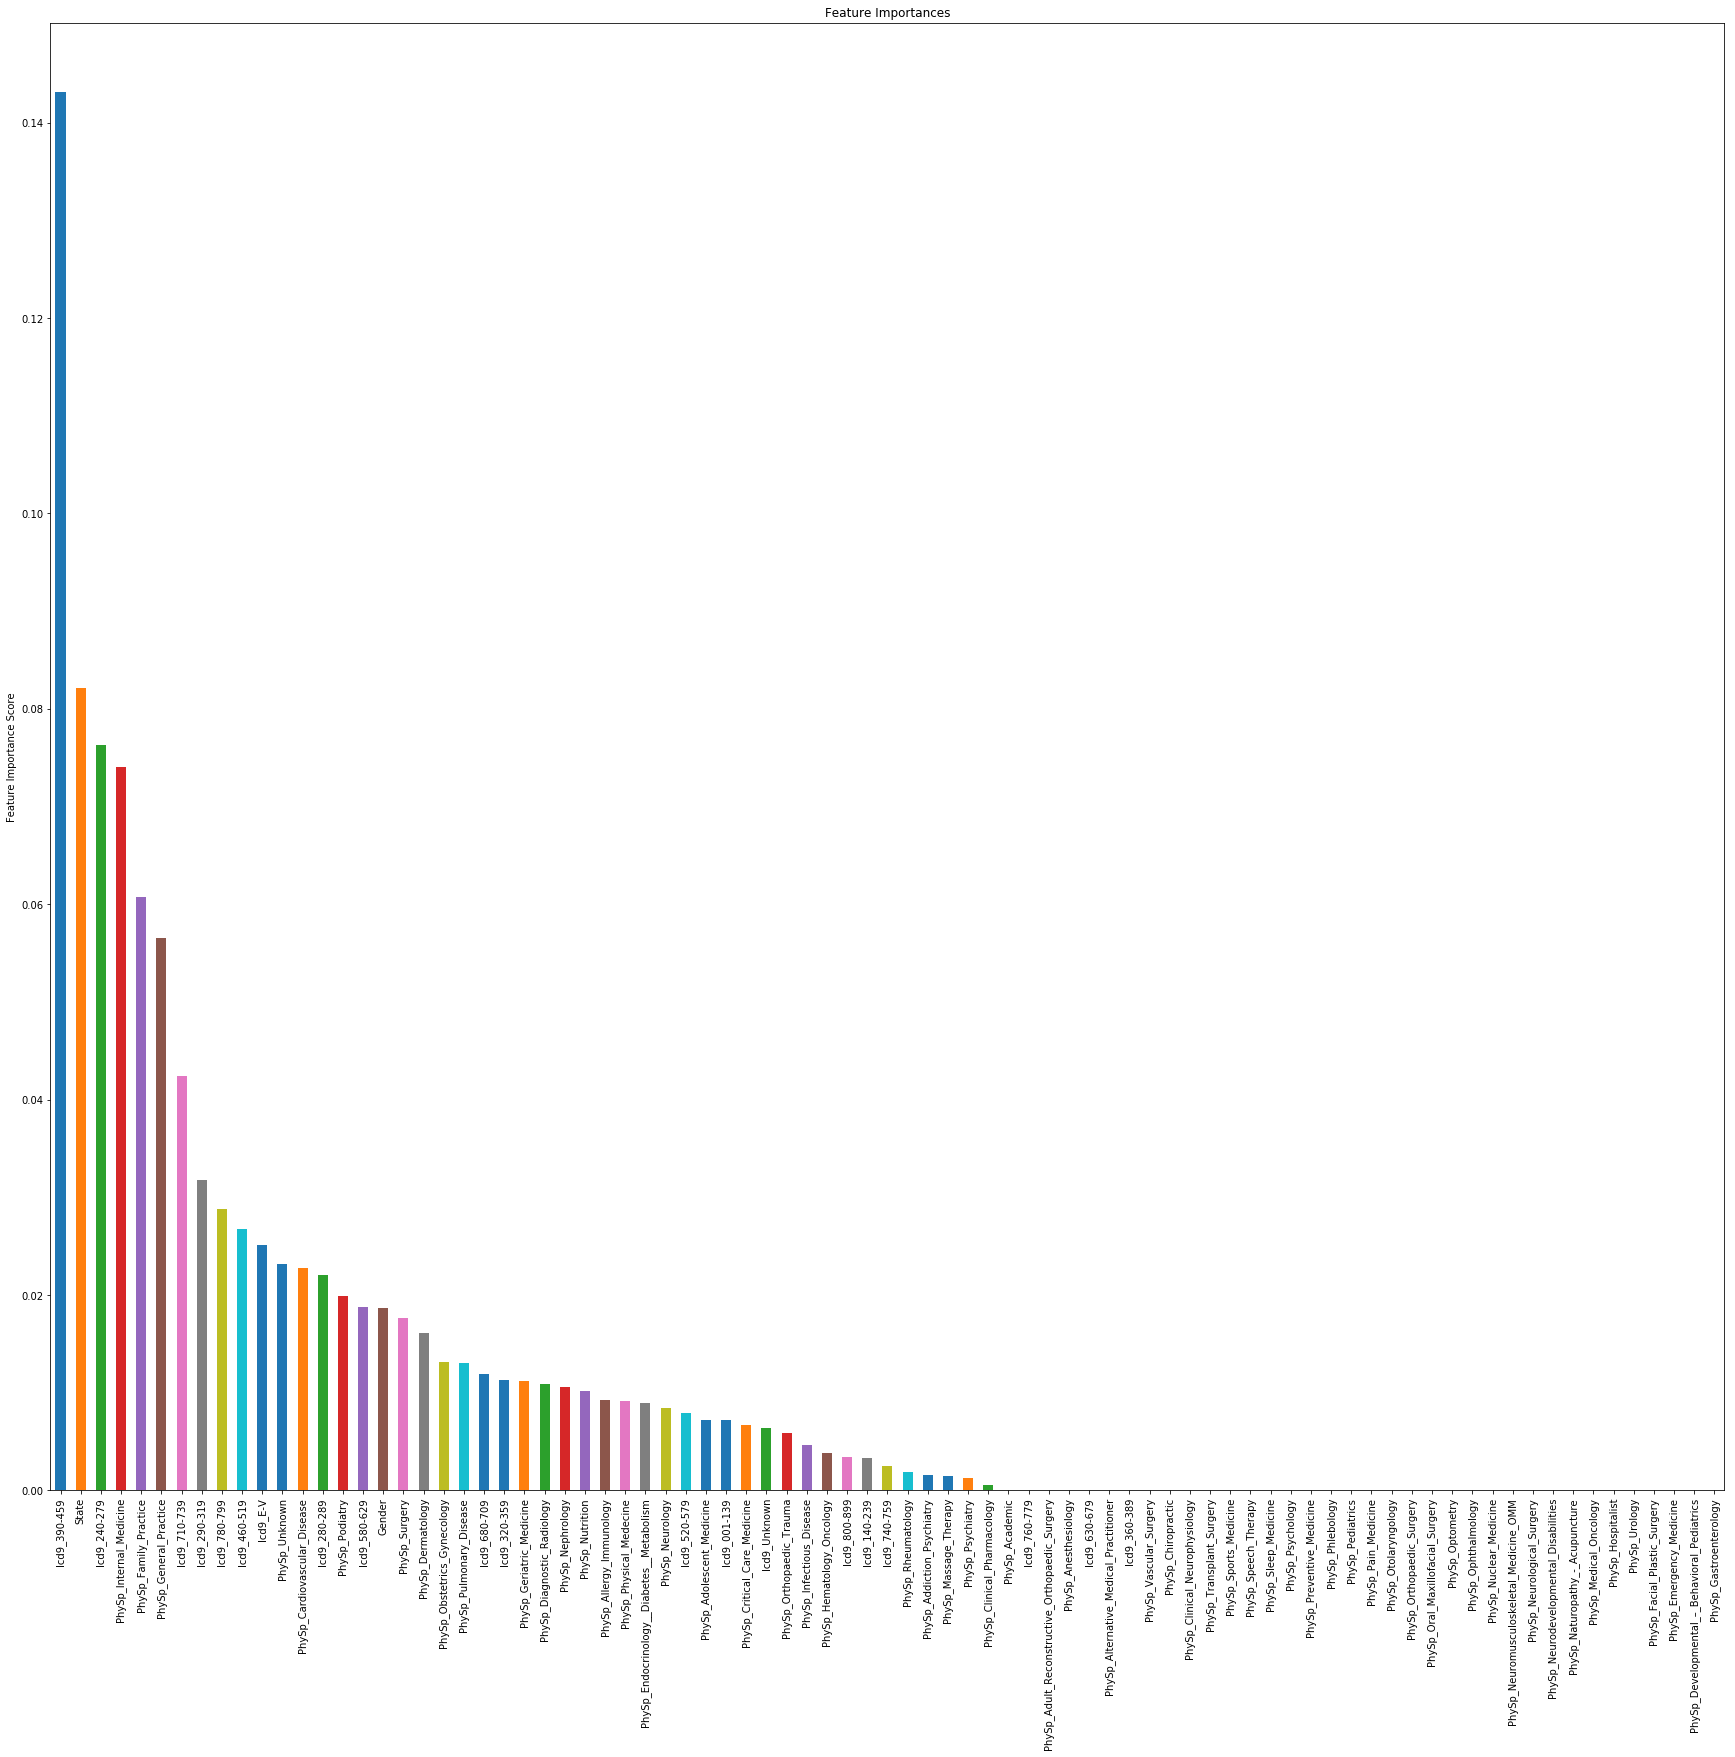

In [23]:
# Testing Model with all features and default values
predictors2 = labels2

train = _Xtrain.copy()
train['DMIndicator'] = _Ytrain
gbm_cat = GradientBoostingClassifier(random_state=10)
modelfit(gbm_cat, train, predictors2,target,'roc_auc')

## Important Categorical features

In [24]:
imp_cat_features = gbm_cat.feature_importances_.argsort()[::-1][:40]
cat_feature_list = [labels2[i] for i in imp_cat_features]
cat_feature_list

['Icd9_390-459',
 'State',
 'Icd9_240-279',
 'PhySp_Internal_Medicine',
 'PhySp_Family_Practice',
 'PhySp_General_Practice',
 'Icd9_710-739',
 'Icd9_290-319',
 'Icd9_780-799',
 'Icd9_460-519',
 'Icd9_E-V',
 'PhySp_Unknown',
 'PhySp_Cardiovascular_Disease',
 'Icd9_280-289',
 'PhySp_Podiatry',
 'Icd9_580-629',
 'Gender',
 'PhySp_Surgery',
 'PhySp_Dermatology',
 'PhySp_Obstetrics_Gynecology',
 'PhySp_Pulmonary_Disease',
 'Icd9_680-709',
 'Icd9_320-359',
 'PhySp_Geriatric_Medicine',
 'PhySp_Diagnostic_Radiology',
 'PhySp_Nephrology',
 'PhySp_Nutrition',
 'PhySp_Allergy_Immunology',
 'PhySp_Physical_Medecine',
 'PhySp_Endocrinology__Diabetes__Metabolism',
 'PhySp_Neurology',
 'Icd9_520-579',
 'PhySp_Adolescent_Medicine',
 'Icd9_001-139',
 'PhySp_Critical_Care_Medicine',
 'Icd9_Unknown',
 'PhySp_Orthopaedic_Trauma',
 'PhySp_Infectious_Disease',
 'PhySp_Hematology_Oncology',
 'Icd9_800-899']

## Combine all Features

In [25]:
labels_all = cat_feature_list+med_feature_list+labels1
labels_all += ['ID']
labels_all

['Icd9_390-459',
 'State',
 'Icd9_240-279',
 'PhySp_Internal_Medicine',
 'PhySp_Family_Practice',
 'PhySp_General_Practice',
 'Icd9_710-739',
 'Icd9_290-319',
 'Icd9_780-799',
 'Icd9_460-519',
 'Icd9_E-V',
 'PhySp_Unknown',
 'PhySp_Cardiovascular_Disease',
 'Icd9_280-289',
 'PhySp_Podiatry',
 'Icd9_580-629',
 'Gender',
 'PhySp_Surgery',
 'PhySp_Dermatology',
 'PhySp_Obstetrics_Gynecology',
 'PhySp_Pulmonary_Disease',
 'Icd9_680-709',
 'Icd9_320-359',
 'PhySp_Geriatric_Medicine',
 'PhySp_Diagnostic_Radiology',
 'PhySp_Nephrology',
 'PhySp_Nutrition',
 'PhySp_Allergy_Immunology',
 'PhySp_Physical_Medecine',
 'PhySp_Endocrinology__Diabetes__Metabolism',
 'PhySp_Neurology',
 'Icd9_520-579',
 'PhySp_Adolescent_Medicine',
 'Icd9_001-139',
 'PhySp_Critical_Care_Medicine',
 'Icd9_Unknown',
 'PhySp_Orthopaedic_Trauma',
 'PhySp_Infectious_Disease',
 'PhySp_Hematology_Oncology',
 'Icd9_800-899',
 'MedicationName_Lisinopril oral tablet',
 'MedicationName_Zocor (simvastatin) oral tablet',
 'Medicat

## Base Benchmark Model

In [26]:
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels_all],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

In [27]:
labels_all.pop(labels_all.index('ID'))

'ID'


 Model Report: 
Accuracy :  0.8590001340302909
AUC score (Train): 0.8820536688781871
CV Score - Mean : 0.8177252 | Std : 0.009315177 | Min : 0.8005374 | Max : 0.8252804


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

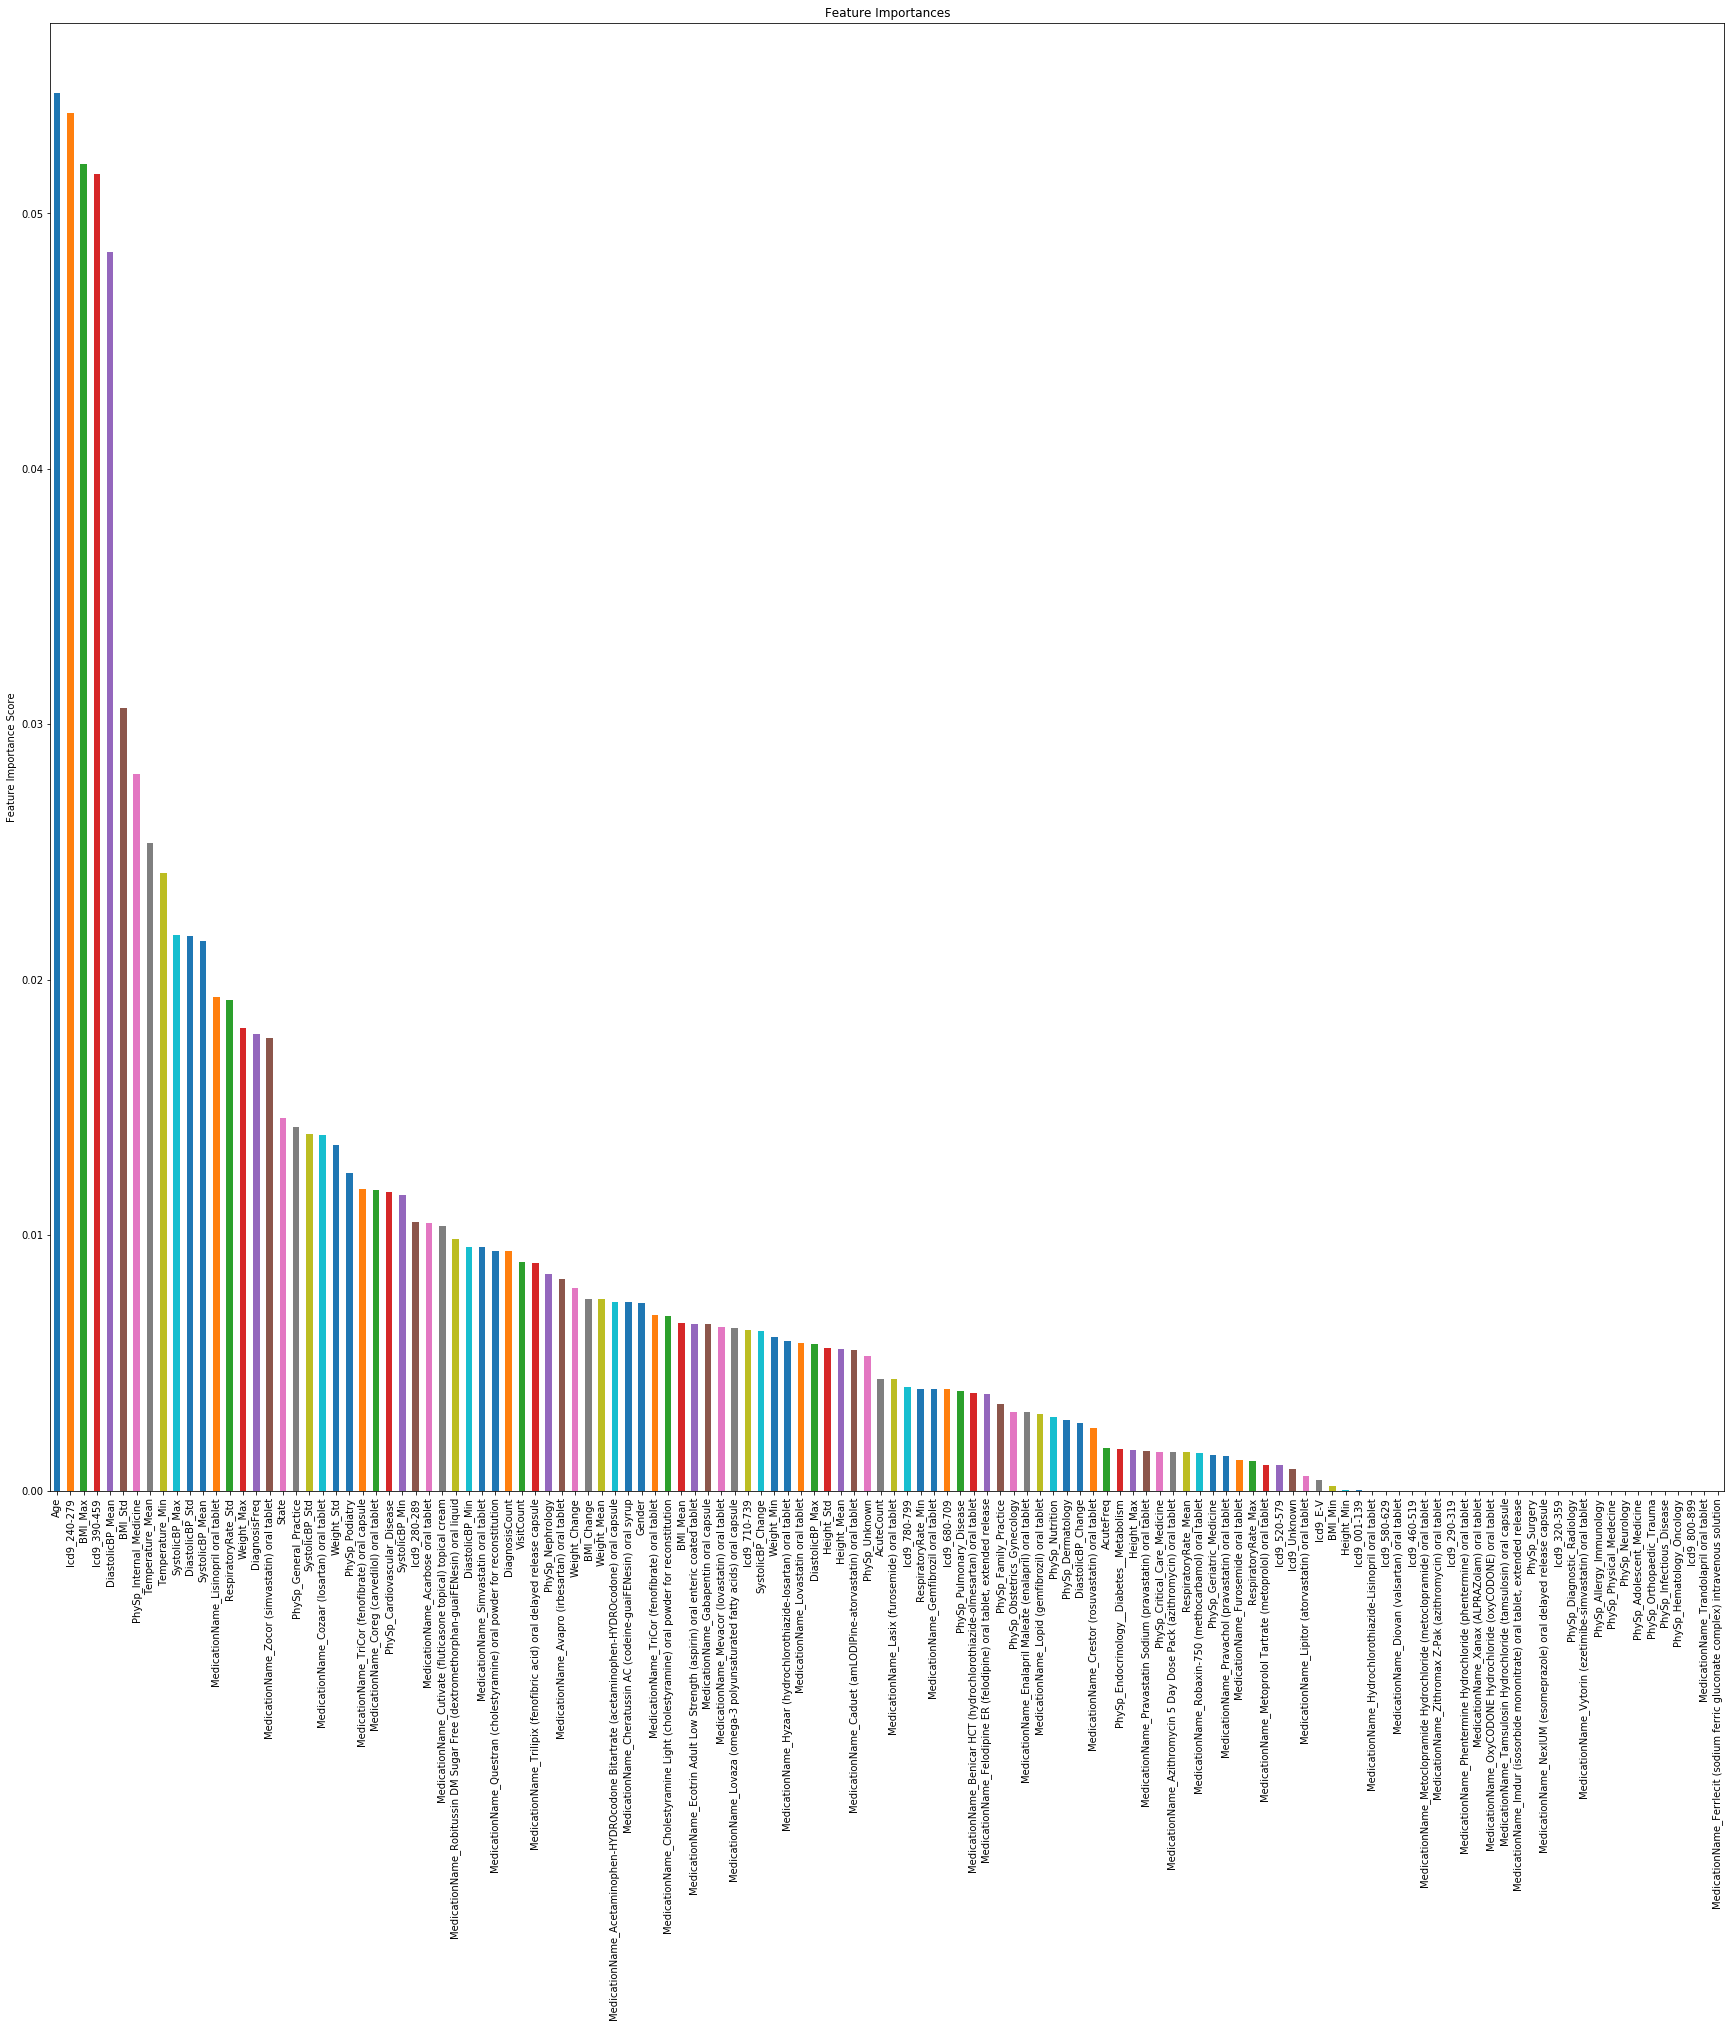

In [28]:
#Using all important features

train = _Xtrain.copy()
train['DMIndicator'] = _Ytrain
predictors = labels_all
gbm_all = GradientBoostingClassifier(random_state=10)
modelfit(gbm_all, train, predictors,target,'roc_auc')

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(random_state=10)
#modelfit(rf, train, predictors,target,'roc_auc')

In [ ]:
#ypred2_model = rf.predict(valid[labels_all])

#print ("====== Model validation ======")
#print ("Summary results")
#print ("ROC AUC - of the model:", round(metrics.roc_auc_score(ypred2_model,valid[target]),3))


 Model Report: 
Accuracy :  0.8590001340302909
AUC score (Train): 0.8820536688781871
CV Score - Mean : 0.8177831 | Std : 0.009269773 | Min : 0.8007478 | Max : 0.8255498


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

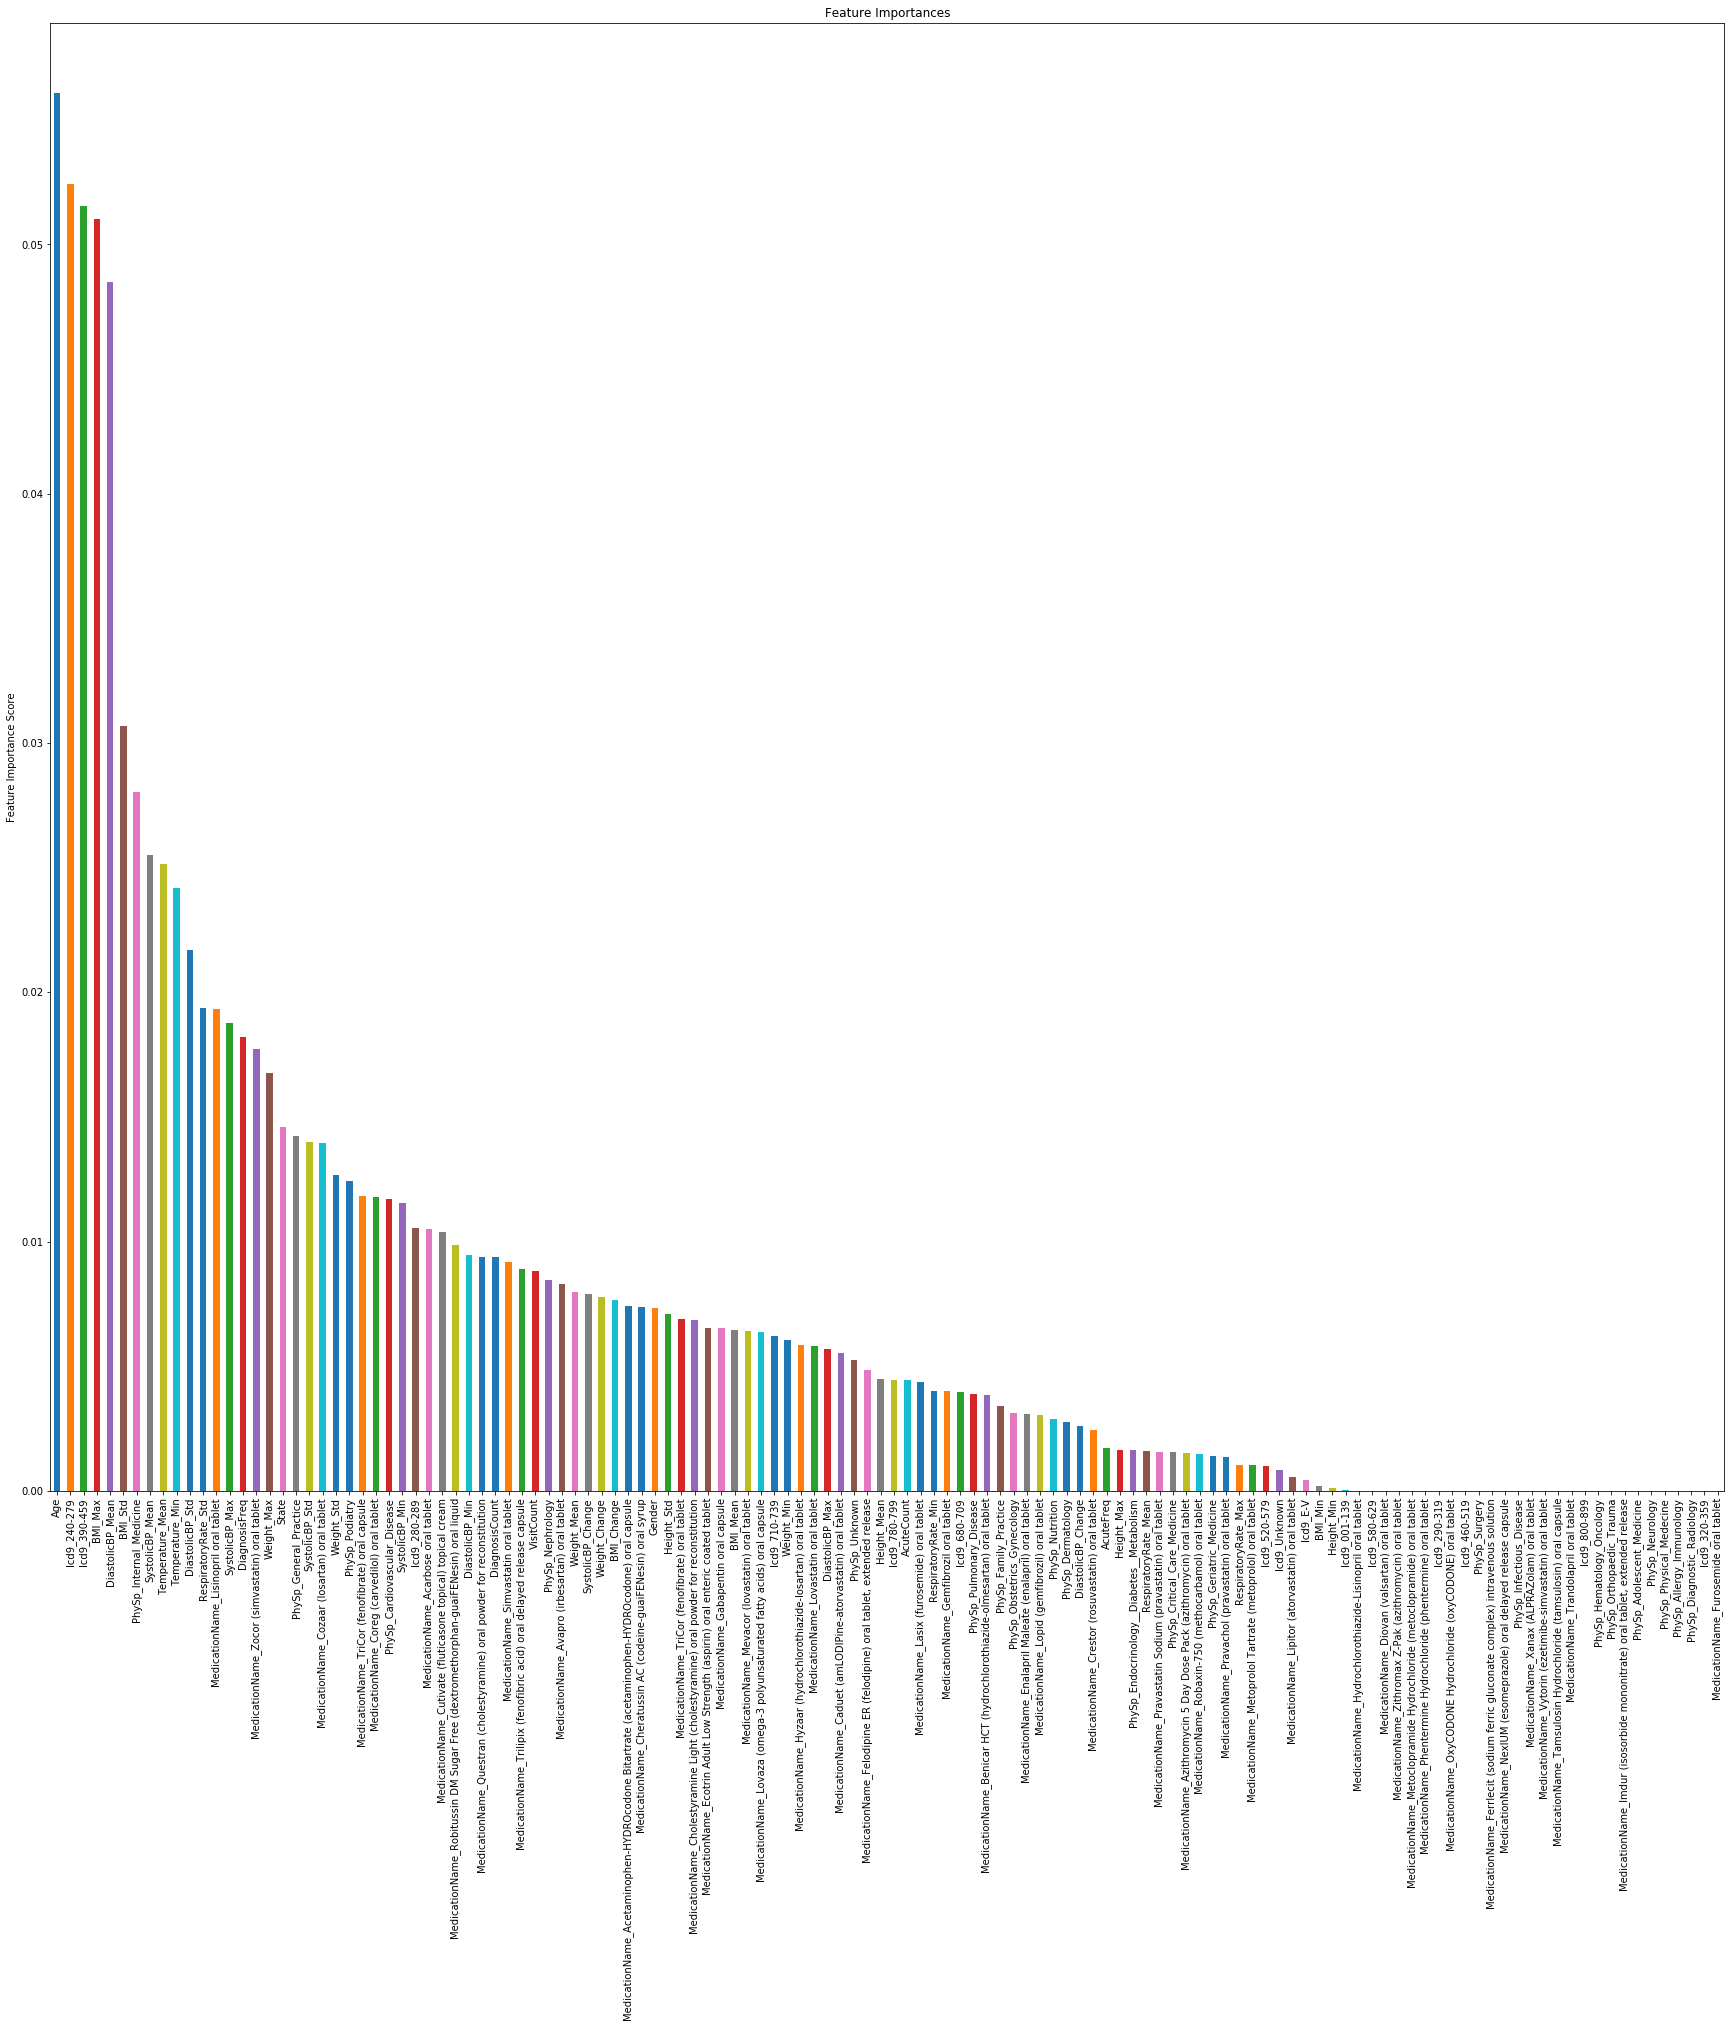

In [90]:
modelfit(gbm_all, train, predictors,target,'roc_auc')

## Parameters Tuning

In [65]:
#tuning parameters
#Min_sample_slpit=100 (1% of total records)
#max_depth=8 for pre-pruning to decrease overfitting

predictors = labels_all
param_test1 = {'n_estimators':np.arange(10,151,20)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=100,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])



GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150])},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [66]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.79199, std: 0.01410, params: {'n_estimators': 10},
  mean: 0.80831, std: 0.01416, params: {'n_estimators': 30},
  mean: 0.81243, std: 0.01349, params: {'n_estimators': 50},
  mean: 0.81313, std: 0.01211, params: {'n_estimators': 70},
  mean: 0.81231, std: 0.01187, params: {'n_estimators': 90},
  mean: 0.81147, std: 0.01072, params: {'n_estimators': 110},
  mean: 0.81000, std: 0.01047, params: {'n_estimators': 130},
  mean: 0.80996, std: 0.00974, params: {'n_estimators': 150}],
 {'n_estimators': 70},
 0.8131326160255519)

## Tuning Max Depth and min sample split

In [68]:
param_test2 = {'max_depth':np.arange(2,16,2), 'min_samples_split':np.arange(50,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.80369, std: 0.01176, params: {'max_depth': 2, 'min_samples_split': 50},
  mean: 0.80386, std: 0.01213, params: {'max_depth': 2, 'min_samples_split': 250},
  mean: 0.80371, std: 0.01110, params: {'max_depth': 2, 'min_samples_split': 450},
  mean: 0.80325, std: 0.01216, params: {'max_depth': 2, 'min_samples_split': 650},
  mean: 0.80314, std: 0.01200, params: {'max_depth': 2, 'min_samples_split': 850},
  mean: 0.81182, std: 0.01358, params: {'max_depth': 4, 'min_samples_split': 50},
  mean: 0.81270, std: 0.01146, params: {'max_depth': 4, 'min_samples_split': 250},
  mean: 0.81179, std: 0.01205, params: {'max_depth': 4, 'min_samples_split': 450},
  mean: 0.81106, std: 0.01140, params: {'max_depth': 4, 'min_samples_split': 650},
  mean: 0.81304, std: 0.01247, params: {'max_depth': 4, 'min_samples_split': 850},
  mean: 0.81751, std: 0.01074, params: {'max_depth': 6, 'min_samples_split': 50},
  mean: 0.81944, std: 0.00901, params: {'max_depth': 6, 'min_samples_split': 250},
  mean:

## Tuning Min Sample Leaf

In [71]:
param_test3 = {'min_samples_leaf':np.arange(2,41,2)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, min_samples_split=450, max_depth=14,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.81972, std: 0.01142, params: {'min_samples_leaf': 2},
  mean: 0.81860, std: 0.00898, params: {'min_samples_leaf': 4},
  mean: 0.81839, std: 0.01177, params: {'min_samples_leaf': 6},
  mean: 0.81861, std: 0.01027, params: {'min_samples_leaf': 8},
  mean: 0.81864, std: 0.00978, params: {'min_samples_leaf': 10},
  mean: 0.81405, std: 0.01259, params: {'min_samples_leaf': 12},
  mean: 0.81658, std: 0.01392, params: {'min_samples_leaf': 14},
  mean: 0.81706, std: 0.00984, params: {'min_samples_leaf': 16},
  mean: 0.81781, std: 0.01233, params: {'min_samples_leaf': 18},
  mean: 0.81724, std: 0.01487, params: {'min_samples_leaf': 20},
  mean: 0.81656, std: 0.01312, params: {'min_samples_leaf': 22},
  mean: 0.81625, std: 0.01381, params: {'min_samples_leaf': 24},
  mean: 0.81932, std: 0.01309, params: {'min_samples_leaf': 26},
  mean: 0.81895, std: 0.01297, params: {'min_samples_leaf': 28},
  mean: 0.81859, std: 0.01196, params: {'min_samples_leaf': 30},
  mean: 0.81658, std: 0.01011

## Refitting model with tuned parameters


 Model Report: 
Accuracy :  0.912746280659429
AUC score (Train): 0.9555480236326787
CV Score - Mean : 0.8239053 | Std : 0.009887046 | Min : 0.8070943 | Max : 0.8357769


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=14,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=450,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False)

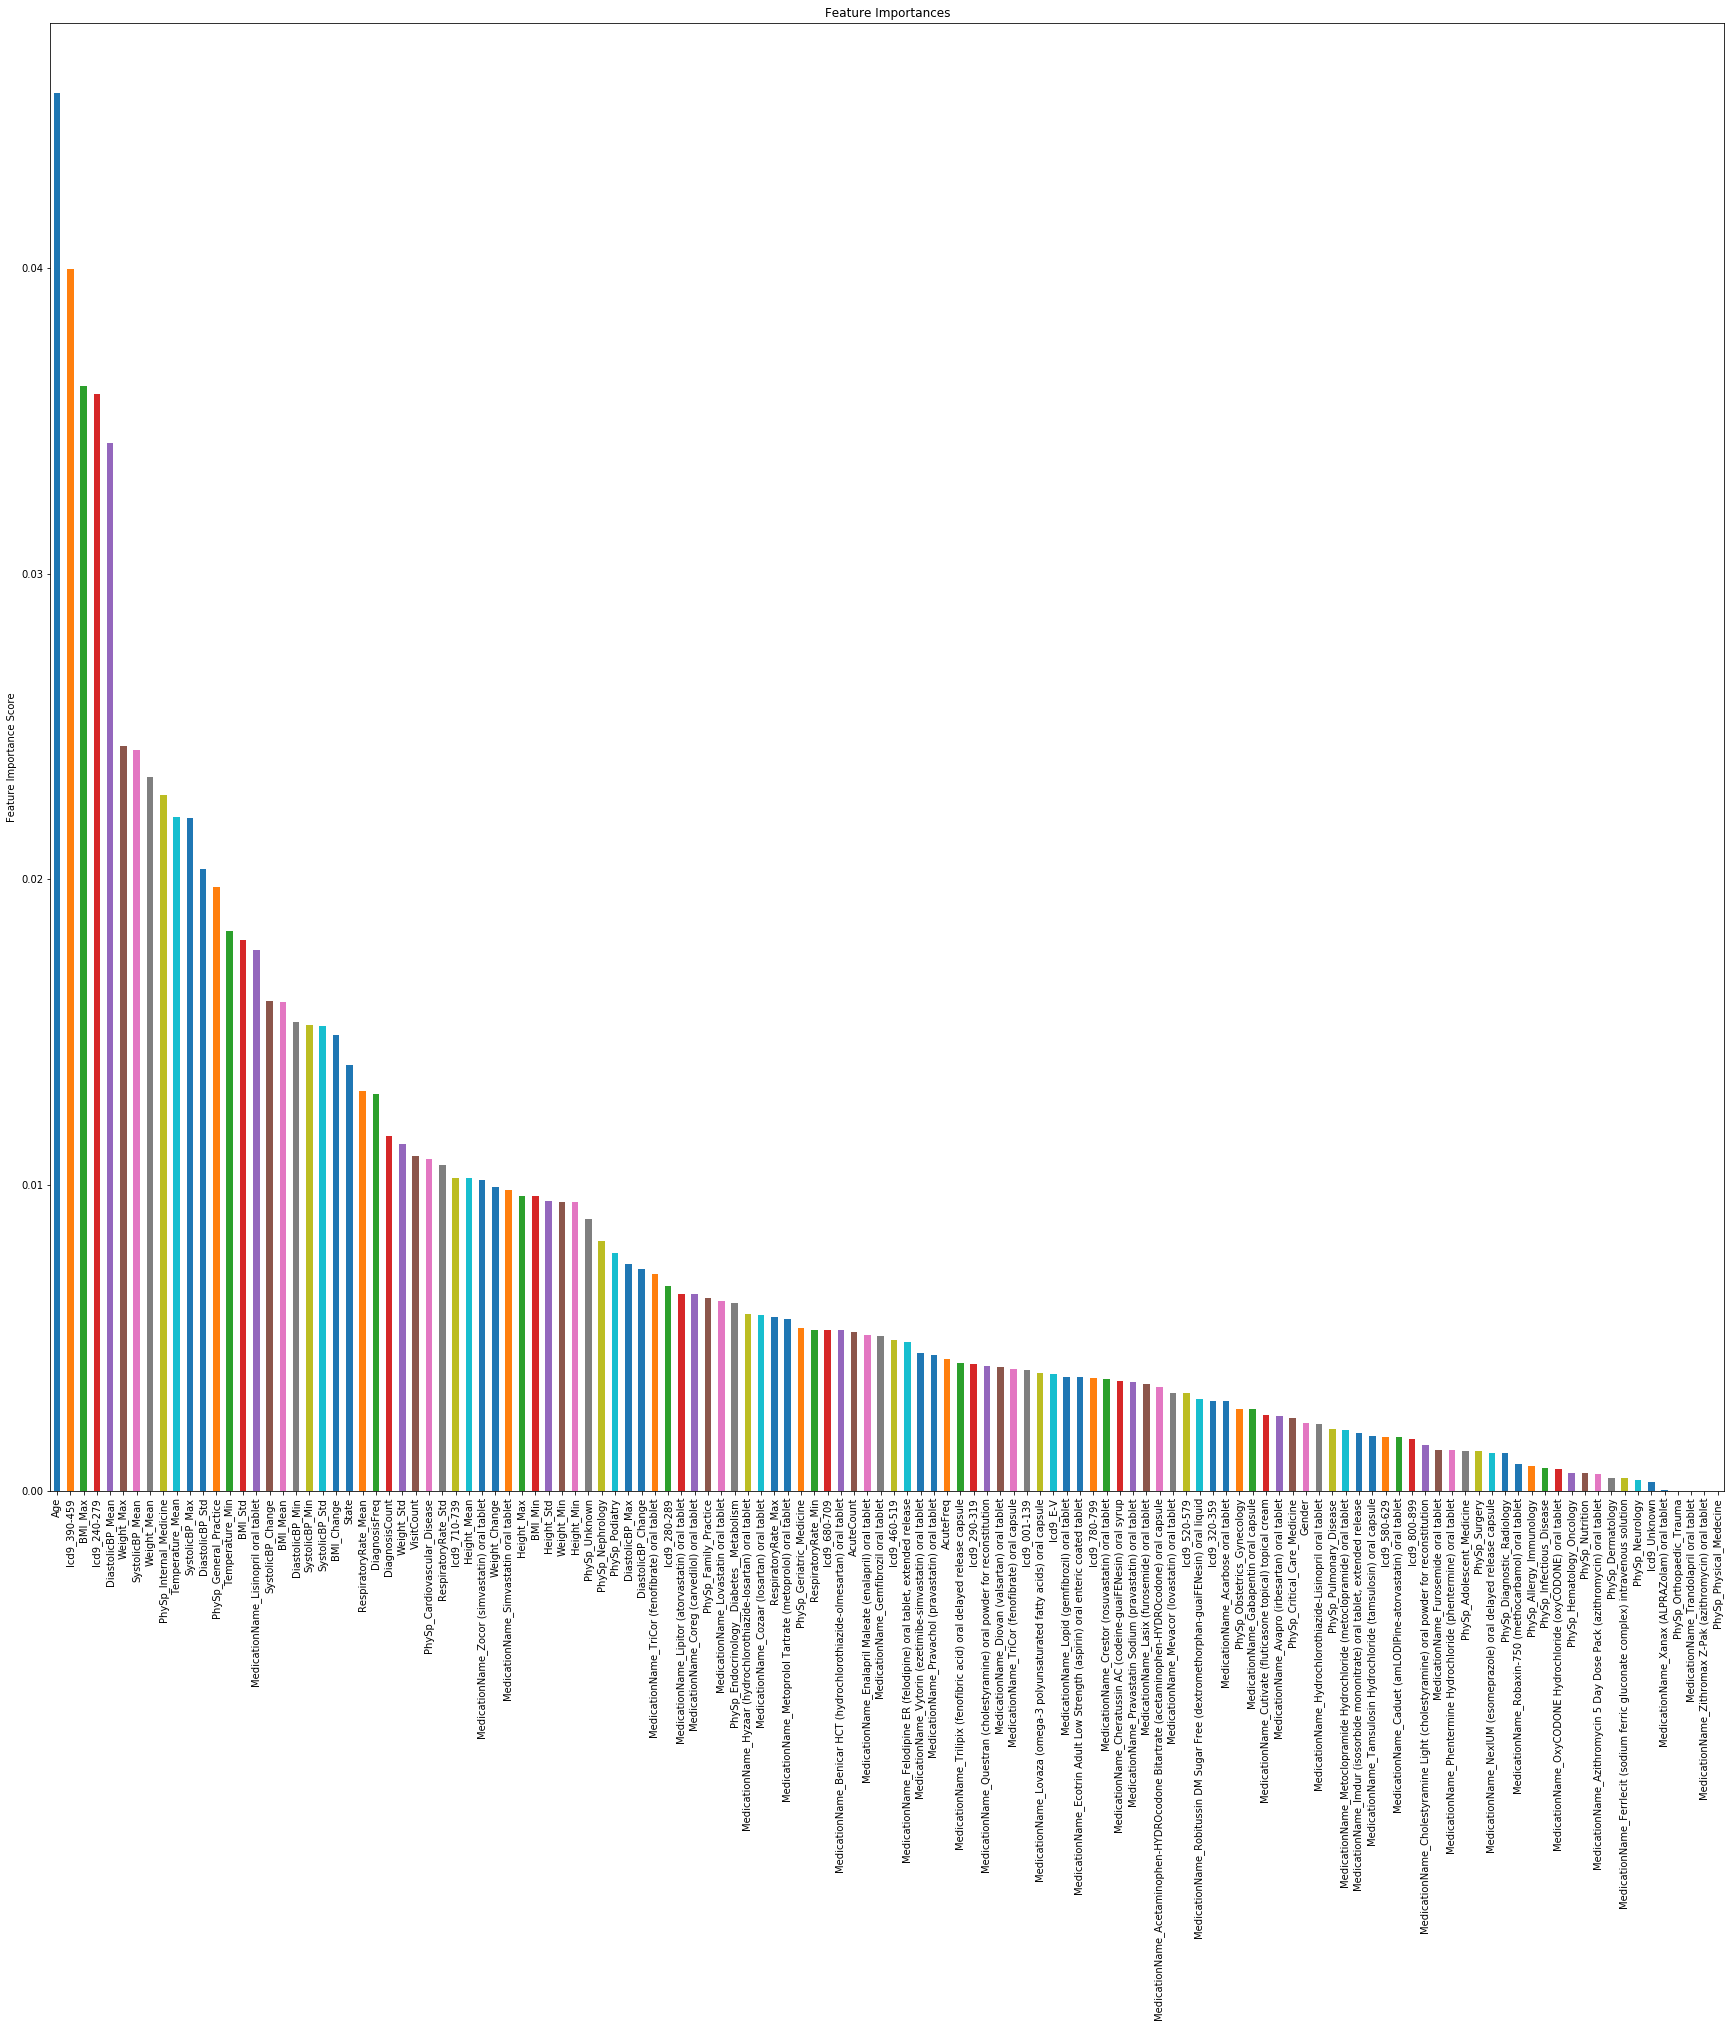

In [91]:
modelfit(gsearch2.best_estimator_, train, predictors,target,'roc_auc')

In [78]:
len(labels_all)

126

## Tuning Max Features

In [80]:
param_test4 = {'max_features':np.arange(7,100,3)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=14, min_samples_split=450, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.82049, std: 0.00771, params: {'max_features': 7},
  mean: 0.82228, std: 0.00651, params: {'max_features': 10},
  mean: 0.82074, std: 0.00920, params: {'max_features': 13},
  mean: 0.82146, std: 0.00890, params: {'max_features': 16},
  mean: 0.81927, std: 0.00938, params: {'max_features': 19},
  mean: 0.82245, std: 0.00893, params: {'max_features': 22},
  mean: 0.81679, std: 0.00722, params: {'max_features': 25},
  mean: 0.82020, std: 0.00771, params: {'max_features': 28},
  mean: 0.81942, std: 0.01066, params: {'max_features': 31},
  mean: 0.81953, std: 0.00806, params: {'max_features': 34},
  mean: 0.81910, std: 0.01100, params: {'max_features': 37},
  mean: 0.81806, std: 0.00853, params: {'max_features': 40},
  mean: 0.81820, std: 0.00770, params: {'max_features': 43},
  mean: 0.82209, std: 0.00998, params: {'max_features': 46},
  mean: 0.81813, std: 0.00885, params: {'max_features': 49},
  mean: 0.81426, std: 0.01032, params: {'max_features': 52},
  mean: 0.81814, std: 0.0

## Tuning Subsample

In [81]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=14,min_samples_split=450, subsample=0.8, random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.81559, std: 0.01062, params: {'subsample': 0.6},
  mean: 0.81549, std: 0.01110, params: {'subsample': 0.7},
  mean: 0.81846, std: 0.00882, params: {'subsample': 0.75},
  mean: 0.81895, std: 0.00804, params: {'subsample': 0.8},
  mean: 0.81968, std: 0.00880, params: {'subsample': 0.85},
  mean: 0.81632, std: 0.00949, params: {'subsample': 0.9}],
 {'subsample': 0.85},
 0.8196777375335389)

## Tuning Learning rate and n estimators


 Model Report: 
Accuracy :  0.9309744002144484
AUC score (Train): 0.9750941721400179
CV Score - Mean : 0.8199765 | Std : 0.008203914 | Min : 0.806397 | Max : 0.8310712


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=14,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=450,
              min_weight_fraction_leaf=0.0, n_estimators=700,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

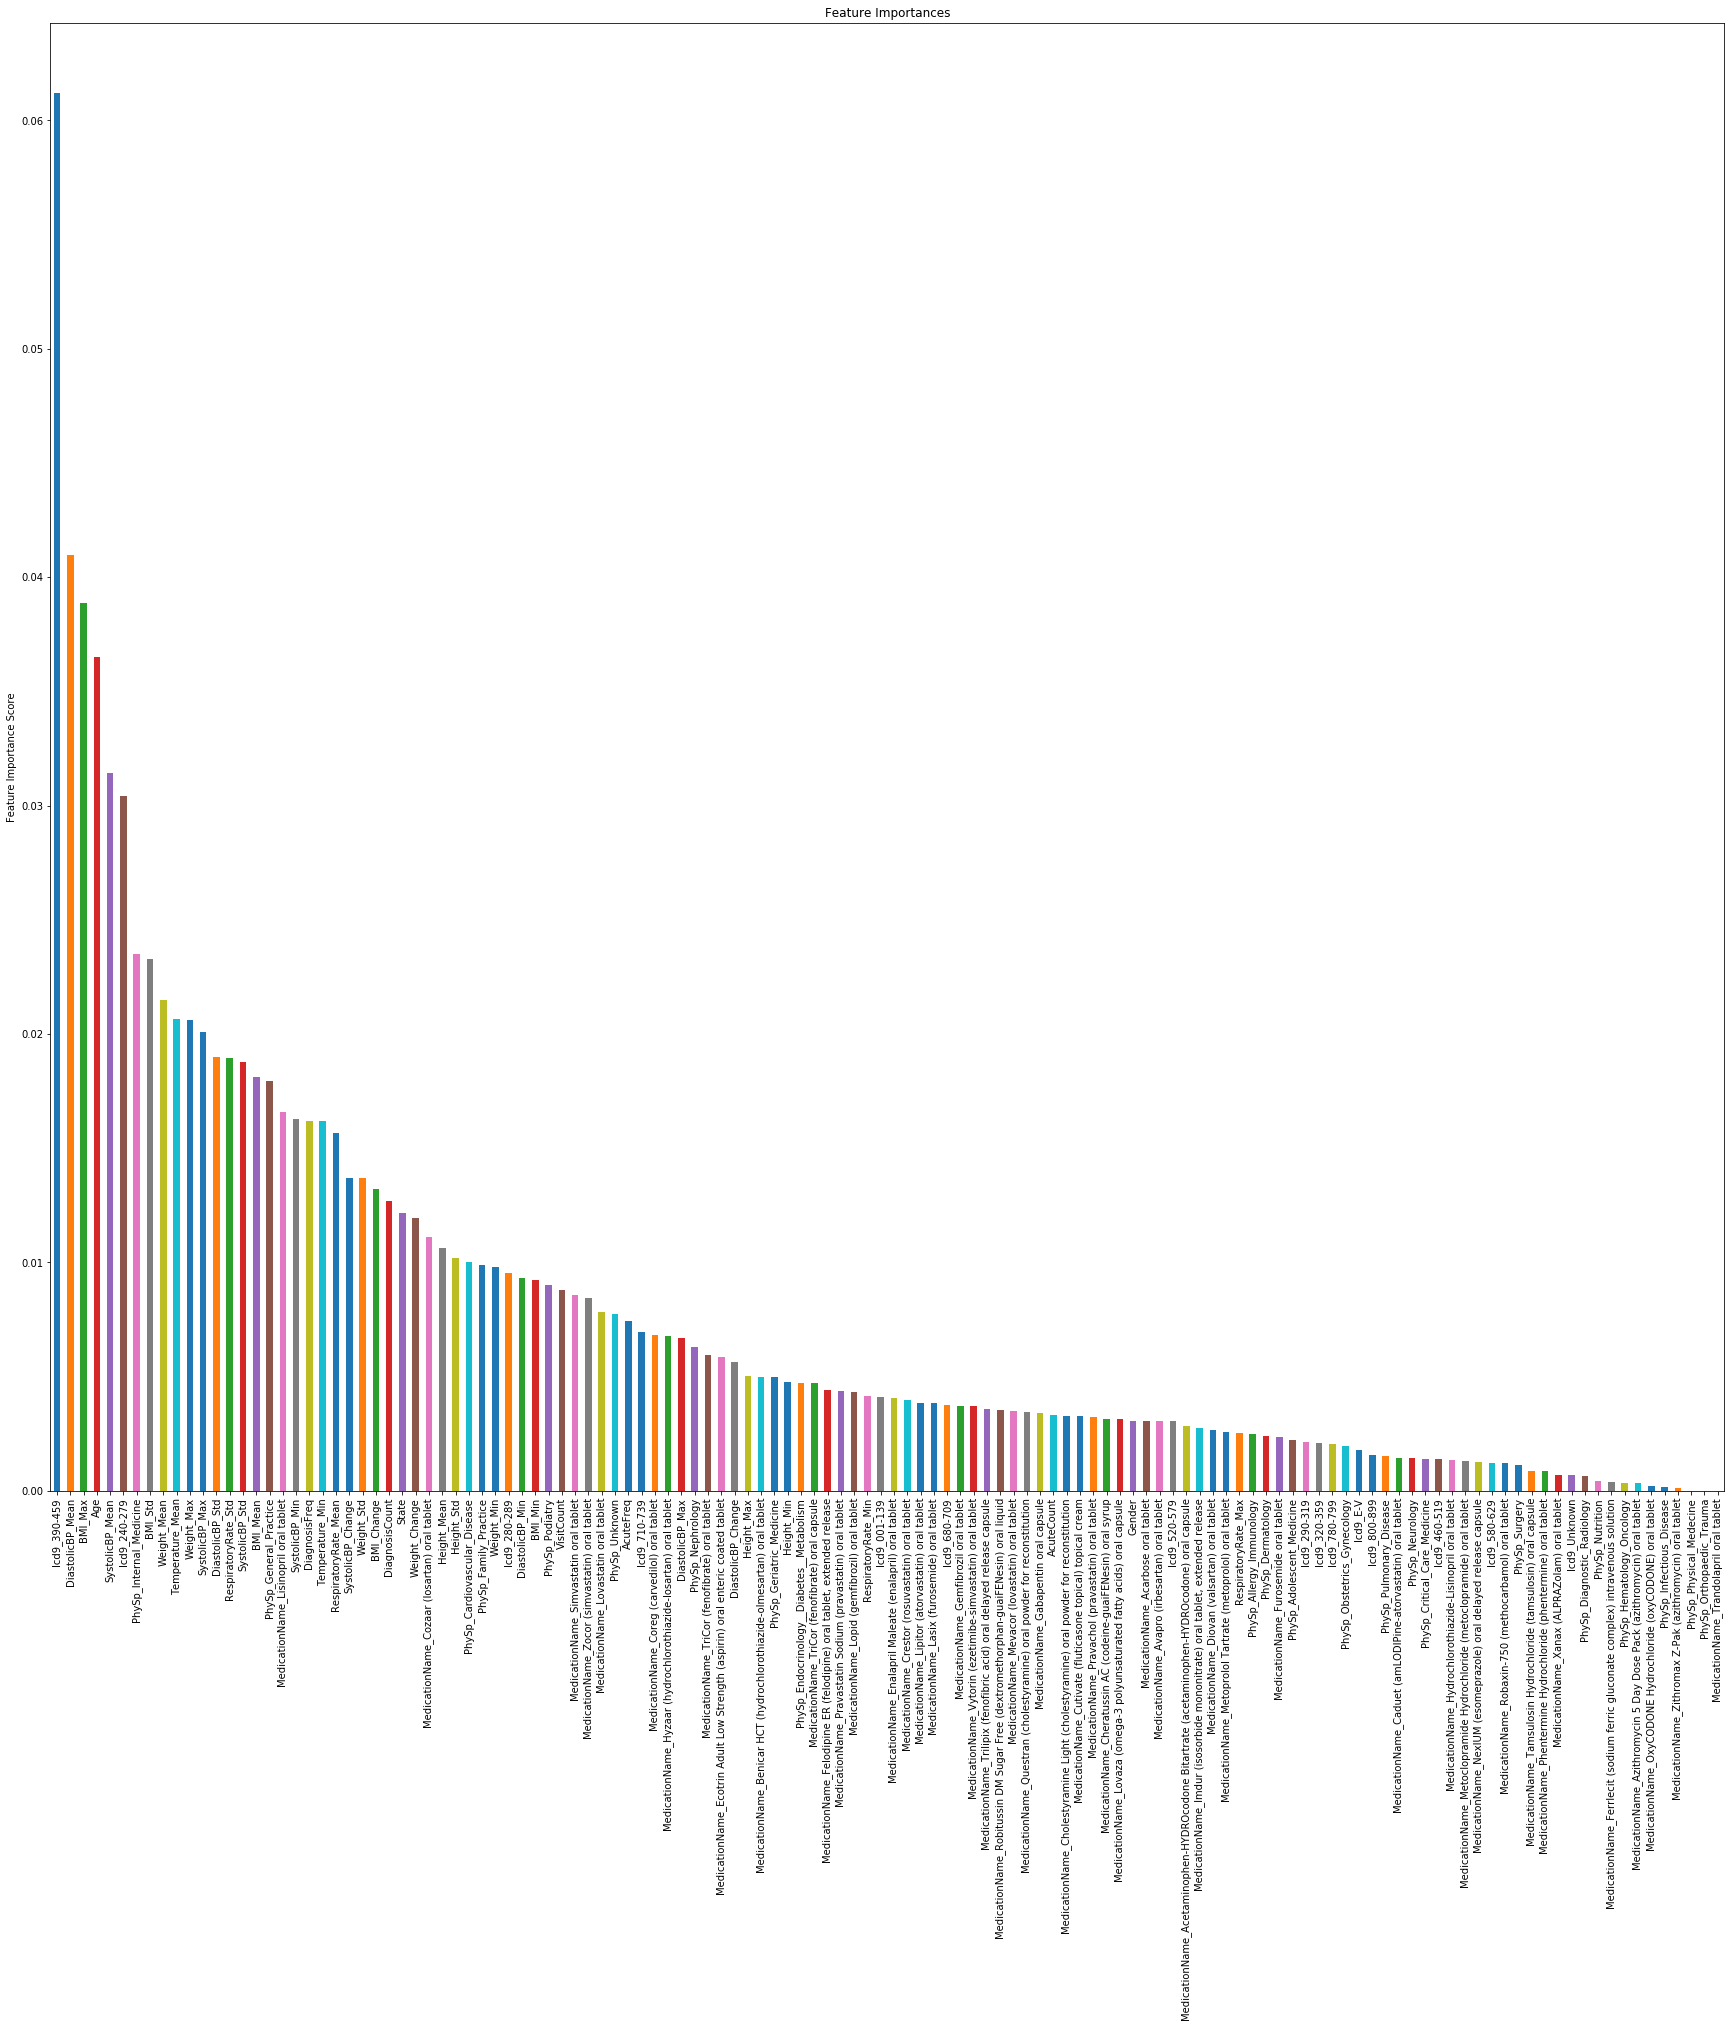

In [94]:
predictors = labels_all
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=700,max_depth=14, min_samples_split=450,random_state=10)
modelfit(gbm_tuned_1, train, predictors,target,'roc_auc')

## Making Final predictions

In [96]:
#Make Predictions
valid = data[data.ID.isin(_valid_ids)]
ypred_model = gsearch2.predict(valid[labels_all])

print ("====== Model validation ======")
print ("Summary results")
print ("ROC AUC - of the model:", round(metrics.roc_auc_score(ypred_model,valid[target]),3))

====== Model validation ======
Summary results
ROC AUC - of the model: 0.727


In [97]:
ypred_tune = gbm_tuned_1.predict(valid[labels_all])

print ("====== Model validation ======")
print ("Summary results")
print ("ROC AUC - of the model:", round(metrics.roc_auc_score(ypred_tune,valid[target]),3))

====== Model validation ======
Summary results
ROC AUC - of the model: 0.714
